In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
from implementations import *
from proj1_helpers import *
from plots import *
from Feature_expansion import *

## Load the training data into feature matrix, class labels, and event ids:

In [2]:
DATA_TRAIN_PATH = '../data/train.csv'
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

## EDA

### Some details to get started (from Aicrowd instructions):
* All variables are floating point, except PRI_jet_num which is integer
* Variables prefixed with PRI (for PRImitives) are “raw” quantities about the bunch collision as measured by the detector.
* Variables prefixed with DER (for DERived) are quantities computed from the primitive features, which were selected by the physicists of ATLAS.
* It can happen that for some entries some variables are meaningless or cannot be computed; in this case, their value is −999.0, which is outside the normal range of all variables.

In [81]:
#Features names according to train.csv file
col_names = ['DER_mass_MMC',
 'DER_mass_transverse_met_lep',
 'DER_mass_vis',
 'DER_pt_h',
 'DER_deltaeta_jet_jet',
 'DER_mass_jet_jet',
 'DER_prodeta_jet_jet',
 'DER_deltar_tau_lep',
 'DER_pt_tot',
 'DER_sum_pt',
 'DER_pt_ratio_lep_tau',
 'DER_met_phi_centrality',
 'DER_lep_eta_centrality',
 'PRI_tau_pt',
 'PRI_tau_eta',
 'PRI_tau_phi',
 'PRI_lep_pt',
 'PRI_lep_eta',
 'PRI_lep_phi',
 'PRI_met',
 'PRI_met_phi',
 'PRI_met_sumet',
 'PRI_jet_num',
 'PRI_jet_leading_pt',
 'PRI_jet_leading_eta',
 'PRI_jet_leading_phi',
 'PRI_jet_subleading_pt',
 'PRI_jet_subleading_eta',
 'PRI_jet_subleading_phi',
 'PRI_jet_all_pt']

dict_indexToName = dict(zip(range(len(col_names)),col_names))
print("Number of features: ", len(col_names))

num_datapoints = ids.shape[0]
print("Number of datapoints: ", num_datapoints)

Number of features:  30
Number of datapoints:  250000


### Here is a description of all our features ([Source](https://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf))

| Feature name                | Type | Description 
|-----------------------------|---------------|--------------------------------------------------------
| Prediction                  | Binary        | 1 = Signal; -1 = background
| DER_mass_MMC                | Continuous    | The estimated mass mH of the Higgs boson candidate.
| DER_mass_transverse_met_lep | Continuous    | The transverse mass between the missing transverse energy and the lepton.
| DER_mass_vis                | Continuous    | The invariant mass of the hadronic tau and the lepton.
| DER_pt_h                    | Continuous    | The modulus of the vector sum of the transverse momentum.
| DER_deltaeta_jet_jet        | Continuous    | The absolute value of the pseudorapidity separation between the two jets.
| DER_mass_jet_jet            | Continuous    | The invariant mass of the two jets.
| DER_prodeta_jet_jet         | Continuous    | The product of the pseudorapidities of the two jets.
| DER_deltar_tau_lep          | Continuous    | The R separation between the hadronic tau and the lepton.
| DER_pt_tot                  | Continuous    | The modulus of the vector sum of the missing transverse and the transverse momenta.
| DER_sum_pt                  | Continuous    | The sum of the moduli of the transverse momenta of the hadronic tau, the lepton, the leading jet and the subleading jet and the other jets.
| DER_pt_ratio_lep_tau        | Continuous    | The ratio of the transverse momenta of the lepton and the hadronic tau.
| DER_met_phi_centralit       | Continuous    | The centrality of the azimuthal angle of the missing transverse energy vector.
| DER_lep_eta_centrality      | Continuous    | The centrality of the pseudorapidity of the lepton w.r.t. the two jets.
| PRI_tau_pt                  | Continuous    | The transverse momentum of the hadronic tau.
| PRI_tau_eta                 | Continuous    | The pseudorapidity η of the hadronic tau.
| PRI_tau_phi                 | Continuous    | The azimuth angle φ of the hadronic tau.
| PRI_lep_pt                  | Continuous    | The transverse momentum of the lepton (electron or muon).
| PRI_lep_eta                 | Continuous    | The pseudorapidity η of the lepton. 
| PRI_lep_phi                 | Continuous    | The azimuth angle φ of the lepton.
| PRI_met                     | Continuous    | The missing transverse energy
| PRI_met_phi                 | Continuous    | The azimuth angle φ of the missing transverse energy.
| PRI_met_sumet               | Continuous    | The total transverse energy in the detector.
| PRI_jet_num                 | Integer       | The number of jets (values of 0, 1, 2 or 3 possible, larger values have been capped at 3).
| PRI_jet_leading_pt          | Continuous    | The transverse momentum of the leading jet.
| PRI_jet_leading_eta         | Continuous    | The pseudorapidity η of the leading jet.
| PRI_jet_leading_phi         | Continuous    | The azimuth angle φ of the leading jet.
| PRI_jet_subleading_pt       | Continuous    | The transverse momentum of the leading jet.
| PRI_jet_subleading_eta      | Continuous    | The pseudorapidity η of the subleading jet.
| PRI_jet_subleading_phi      | Continuous    | The azimuth angle φ of the subleading jet.
| PRI_jet_all_pt              | Continuous    | The scalar sum of the transverse momentum of all the jets of the events.

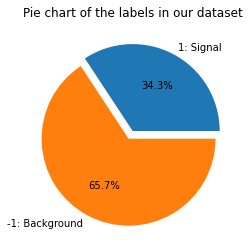

In [9]:
#Balance of the target
Balance(y)

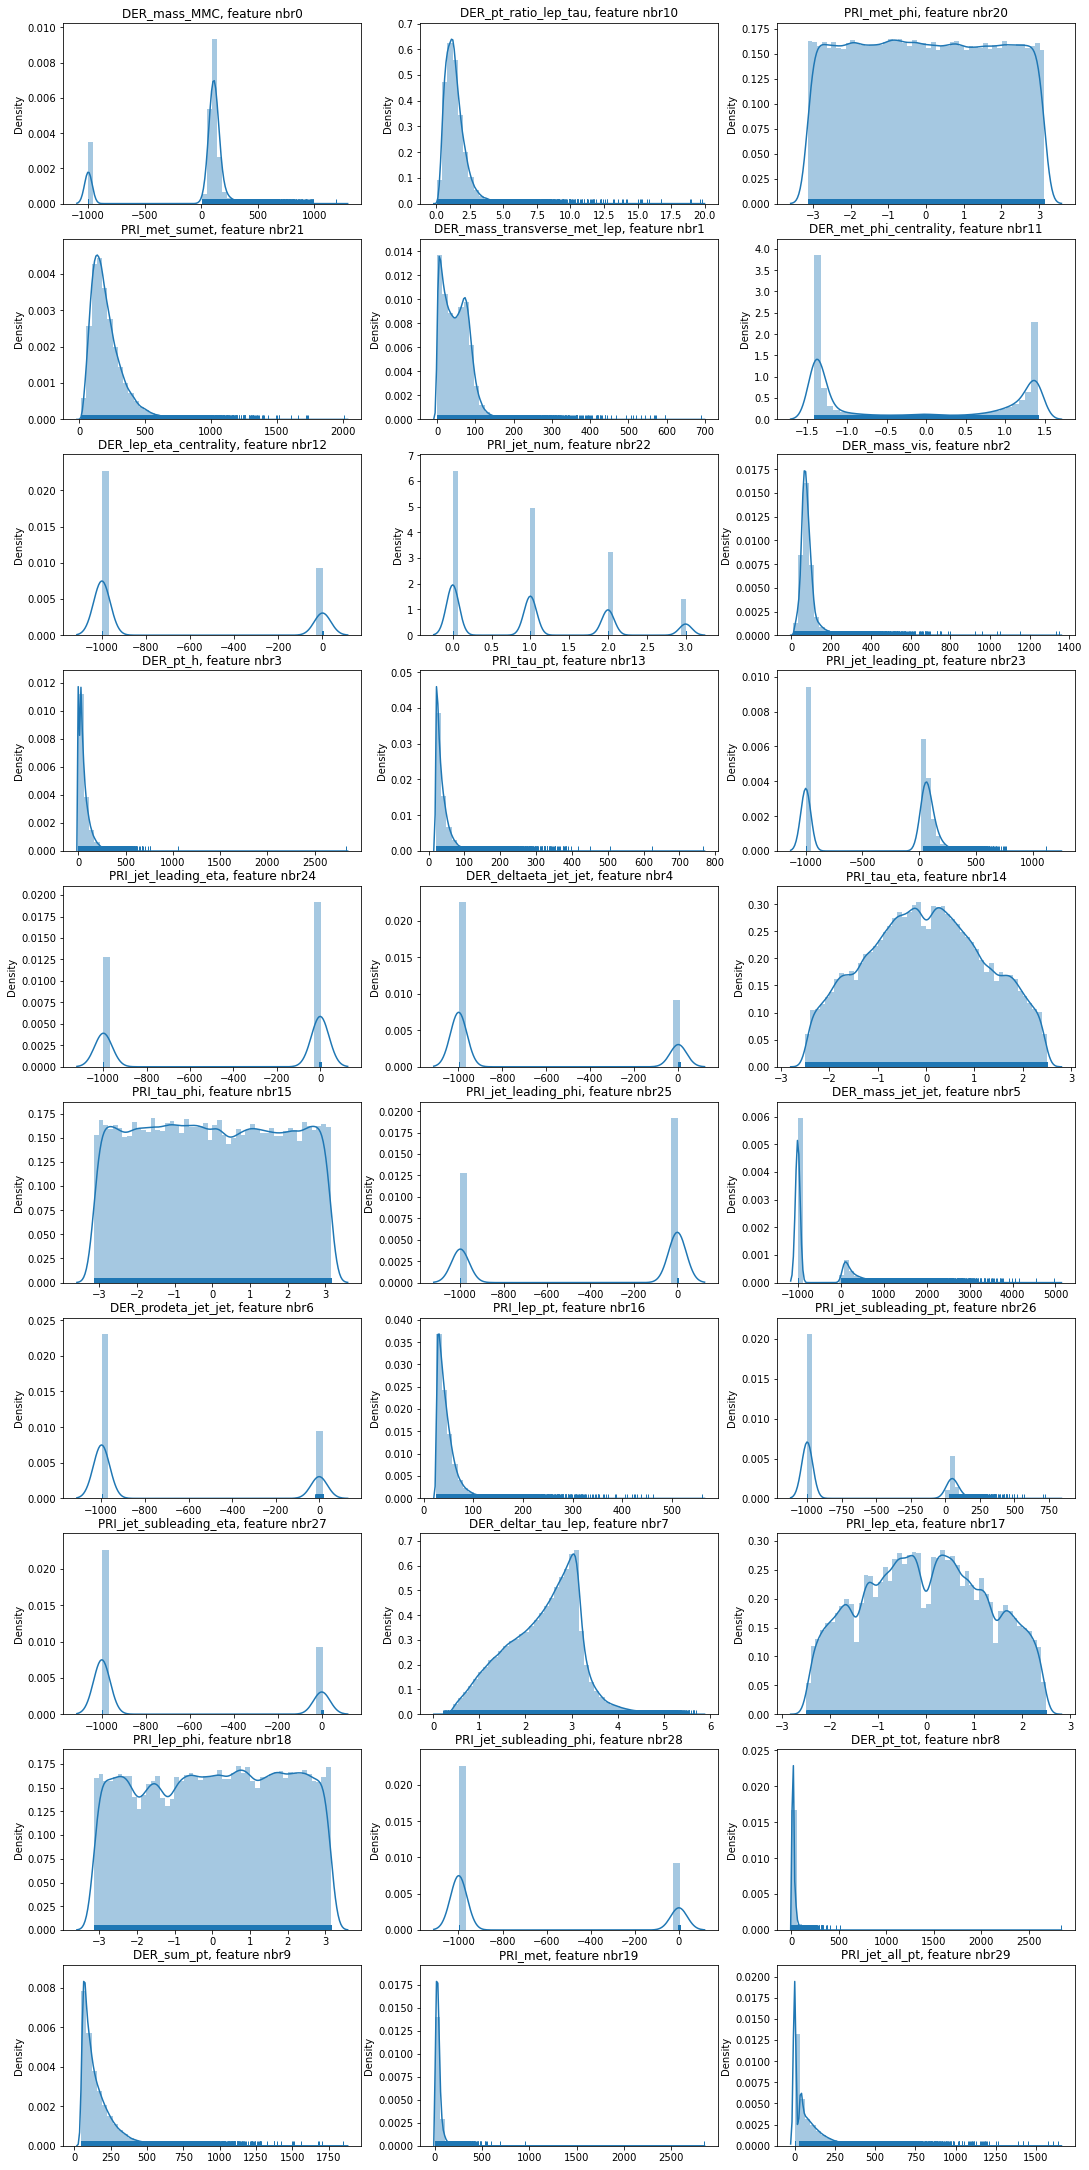

In [10]:
#let's explore the distribution of our features
histogram(tX, dict_indexToName)

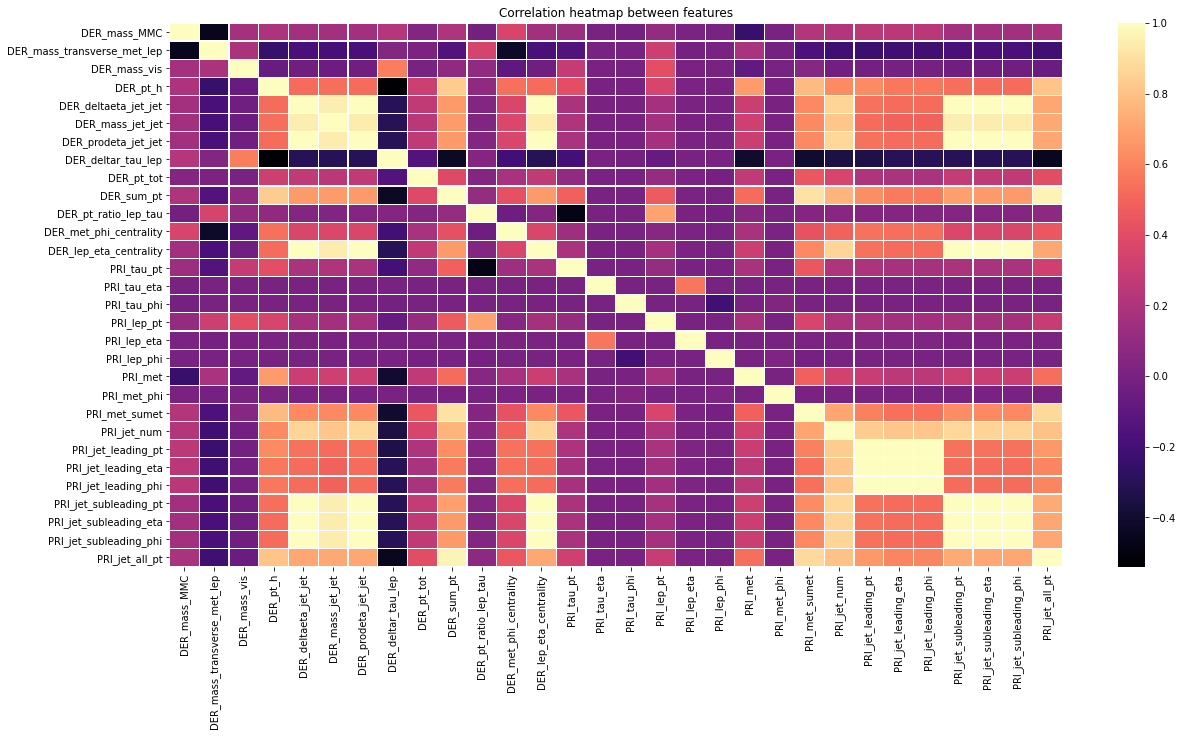

In [11]:
correlation_matrix(tX, col_names)

### Conclusions

**Number of features**
* We have 30 features in total.

**Data types**
* We see that all of our features are continuous except PRI_jet_num which is integer.

**Missing values**
* 23 out of 30 of our features have significant proportions of missing values (value -999).

**Data samples**
* We have 250000 data samples in our training data set.

**Relationships between features**
* We see high correlation between a lot of our features, some of them are derived from the others. We will try to clean that in the next section.

**The dataset is not perfectly balanced**
* We will see later on if we might want to use oversampling or undersampling to have better accuracy.

## Naive prediction

In [69]:
tX_tr, y_tr, tX_te, y_te = split_data(tX, y, ratio=0.8, seed=1)

In [70]:
tX_tr, means, stds = standardize_data(tX_tr)

In [71]:
tX_te = (tX_te - means) / stds

**Least squares:**

In [75]:
w, loss = least_squares(y_tr,tX_tr)
print("wstar={},loss={}".format(w,loss))

wstar=[ 2.94571248e-02 -2.50143878e-01 -2.54134835e-01 -2.70463355e-02
 -1.79974843e+00  3.06486502e-01 -1.03199724e+01  2.68047669e-01
 -2.81221453e-03 -6.21080189e+02 -1.80970213e-01  1.15288656e-01
  2.07854920e+01  1.20470985e+02  2.94867759e-04 -1.99928917e-03
  1.18786184e+02 -2.71428694e-04  1.75784710e-03  1.18201526e-01
 -3.55432050e-04 -6.46127175e-02 -2.00431360e-01 -7.75825004e-02
 -2.87373029e-02  2.55570304e-01  5.85311441e-03 -2.99394088e+00
 -5.75556654e+00  5.26203677e+02],loss=0.38897499326523777


In [76]:
y_guessed = predict_labels(w,tX_te)

In [77]:
accuracy(y_guessed,y_te)

71.66

**Gradient Descent least squares:**

In [78]:
initial_w = np.random.rand(tX_tr.shape[1])
w, loss = least_squares_GD(y_tr, tX_tr, initial_w, max_iters=3000, gamma=1e-7)
print("wstar={},loss={}".format(w,loss))

Current iteration=0, w=[0.3380471  0.76100051 0.12198461 0.19053458 0.48570487 0.20752422
 0.15189438 0.84641232 0.31359674 0.49806601 0.45430976 0.70180127
 0.46331573 0.97694544 0.73214118 0.89785357 0.35380033 0.0137077
 0.08084092 0.18184604 0.07428559 0.22174585 0.95320205 0.57842563
 0.70255385 0.19931573 0.00285325 0.07173529 0.27437094 0.61436762] loss=16.37248570128566
Current iteration=500, w=[0.33797225 0.76101252 0.1219282  0.19033389 0.48548148 0.20731118
 0.15167092 0.84648419 0.31348559 0.49782388 0.45425754 0.70165866
 0.46309231 0.97684856 0.73210242 0.8978083  0.35367845 0.01368236
 0.08084649 0.18172612 0.07427886 0.22152086 0.95294908 0.57820482
 0.70234122 0.19910314 0.00262831 0.07151186 0.27414752 0.61413147] loss=16.35555702666715
Current iteration=1000, w=[0.33789744 0.7610245  0.1218718  0.19013332 0.48525824 0.20709828
 0.15144759 0.84655601 0.31337449 0.49758189 0.45420534 0.70151613
 0.46286903 0.97675173 0.73206367 0.89776303 0.35355661 0.01365703
 0.08085

In [79]:
y_guessed = predict_labels(w,tX_te)

In [80]:
accuracy(y_guessed,y_te)

59.752

**Stochastic Gradient Descent least squares:**

In [81]:
initial_w = np.random.rand(tX_tr.shape[1])
w, loss = least_squares_SGD(y_tr, tX_tr, initial_w, max_iters=2000, gamma=4e-7)

Stochastic Gradient Descent: batch_size=1, max_iterations=2000
Current iteration=0, w=[0.3131084  0.40925362 0.84634451 0.49283682 0.04884497 0.48423448
 0.42042213 0.05705102 0.2187164  0.98249544 0.94507453 0.8073308
 0.37809635 0.55715716 0.92929931 0.54063499 0.60119887 0.64053001
 0.83241316 0.00602406 0.67838174 0.13997246 0.97592294 0.45780491
 0.54516496 0.66850009 0.85262527 0.49939315 0.05269239 0.52004206] loss=30.20732947055772
Current iteration=500, w=[0.3127558  0.40936239 0.84594254 0.49180367 0.04765353 0.48310657
 0.41923043 0.05743203 0.21830561 0.98129995 0.9446253  0.80660836
 0.37690471 0.55671966 0.929035   0.54054246 0.60046145 0.64038647
 0.83227283 0.00551448 0.6781037  0.13892768 0.974646   0.4566913
 0.54409126 0.66742694 0.85143116 0.49820126 0.05150118 0.51889726] loss=30.087878700409885
Current iteration=1000, w=[0.31225094 0.4095439  0.84579868 0.49052565 0.04645423 0.48196707
 0.41803038 0.05796595 0.21779148 0.97992567 0.94432952 0.80573412
 0.3757052  

In [82]:
y_guessed = predict_labels(w,tX_te)

In [83]:
accuracy(y_guessed,y_te)

59.518

**Ridge regression:**

In [84]:
w, loss = ridge_regression(y_tr, tX_tr, lambda_=1e-5)
print("wstar={},loss={}".format(w,loss))

wstar=[ 2.93178562e-02 -2.50834906e-01 -2.54390991e-01 -2.47691194e-02
  1.40917687e+00  3.91807918e-01 -2.08778574e+00  2.68004913e-01
 -3.58001233e-03  1.09713520e-02 -1.80972538e-01  1.16026584e-01
  1.06047907e+00  1.90030824e-01 -3.69371290e-05 -1.25047061e-03
  2.82208176e-01 -8.28447197e-04  2.76006297e-03  1.18161450e-01
  3.20303105e-04 -6.43598685e-02 -2.00154229e-01 -1.24220762e-01
  1.16258341e-01  1.55827261e-01 -6.78803154e-02 -3.14186672e-02
 -4.38507838e-01 -9.32290630e-02],loss=0.3893388083479821


In [85]:
y_guessed = predict_labels(w,tX_te)

In [86]:
accuracy(y_guessed,y_te)

71.658

**Logistic regression:**

In [87]:
initial_w = np.random.rand(tX_tr.shape[1])
w, loss = logistic_regression(y_tr, tX_tr, initial_w, max_iters=2000, gamma=10e-6)
print("wstar={},loss={}".format(w,loss))

Current iteration=0, w=[ 0.5975537   0.12369691  0.58386905  0.1439526  -0.19484882  0.4510288
 -0.01161774  1.13999226  0.12348443  0.33985261 -0.01490234  0.79640605
  0.00906822  0.58546341  0.74003963  0.24279061 -0.03516565  0.20697991
  0.41309629  0.29722557  0.29416283  0.45761042 -0.35993231 -0.14958546
  0.14186068  0.50554013  0.25996675 -0.21578095  0.4812238   0.4969895 ] loss=nan
Current iteration=500, w=[ 18.03663796 -16.26945337 -18.11105486  11.14626283  -2.34091796
  34.86262539  -2.81181751  19.30374657  -5.39218231   1.24849794
  -5.43714842   5.61824253  -2.30996662  28.97181118  -0.14475222
  -0.17335055   8.67012724  -0.04369775   0.27286473   6.73012984
   0.10162956  -4.94856228 -11.86603513   1.44537675   1.57227608
   1.93527338  -2.3175166   -2.58693099  -1.89595414  -6.8783677 ] loss=nan
Current iteration=1000, w=[ 34.82250563 -30.76000327 -34.76432637  21.44875782  -4.50777283
  68.52713906  -5.61193808  36.91545461 -10.24182876   2.36027857
 -10.02459149 

In [88]:
y_guessed = predict_labels(w,tX_te)

In [89]:
accuracy(y_guessed,y_te)

71.114

---

## Feature engineering

After reading the description of the features and examining our data, we noticed that a number of features depend on the PRI_jet_num. In addition, some are undefined for some values of the PRI_jet_num.


**PRI_jet_num: The number of jets (integer with value of 0, 1, 2 or 3; possible larger values have
been capped at 3).**


* **DER_mass_jet_jet** Is undefined if PRI_jet_num ≤ 1.
* **DER_prodeta_jet_jet** Is undefined if PRI_jet_num ≤ 1.
* **DER_pt_tot** The modulus of the vector sum of the missing transverse momenta and the transverse momenta of the hadronic tau, the lepton, the leading jet (if PRI_jet_num ≥ 1) and the subleading jet (if PRI_jet_num = 2) (but not of any additional jets)
* **DER_sum_pt** The sum of the moduli of the transverse momenta of the hadronic tau, the lepton, the leading jet (if PRI_jet_num ≥ 1) and the subleading jet (if PRI_jet_num = 2) and the other jets (if PRI_jet_num = 3).
* **DER_lep_eta_centrality** Is undefined if PRI_jet_num ≤ 1
* **PRI_jet_leading_eta** Is undefined if PRI_jet_num = 0.
* **PRI_jet_leading_phi** Is undefined if PRI_jet_num = 0.
* **PRI_jet_subleading_pt** Is undefined if PRI_jet_num ≤ 1.
* **PRI_jet_subleading_eta** Is undefined if PRI_jet_num ≤1.
* **PRI_jet_subleading_phi** Is undefined if PRI_jet_num ≤1.


In [101]:
sep_jet_nums = seperate_PRI_jet_num(tX)

X0 = tX[sep_jet_nums[0]]
y0 = y[sep_jet_nums[0]]

X1 = tX[sep_jet_nums[1]]
y1 = y[sep_jet_nums[1]]

X2 = tX[sep_jet_nums[2]]
y2 = y[sep_jet_nums[2]]

X3 = tX[sep_jet_nums[3]]
y3 = y[sep_jet_nums[3]]

------

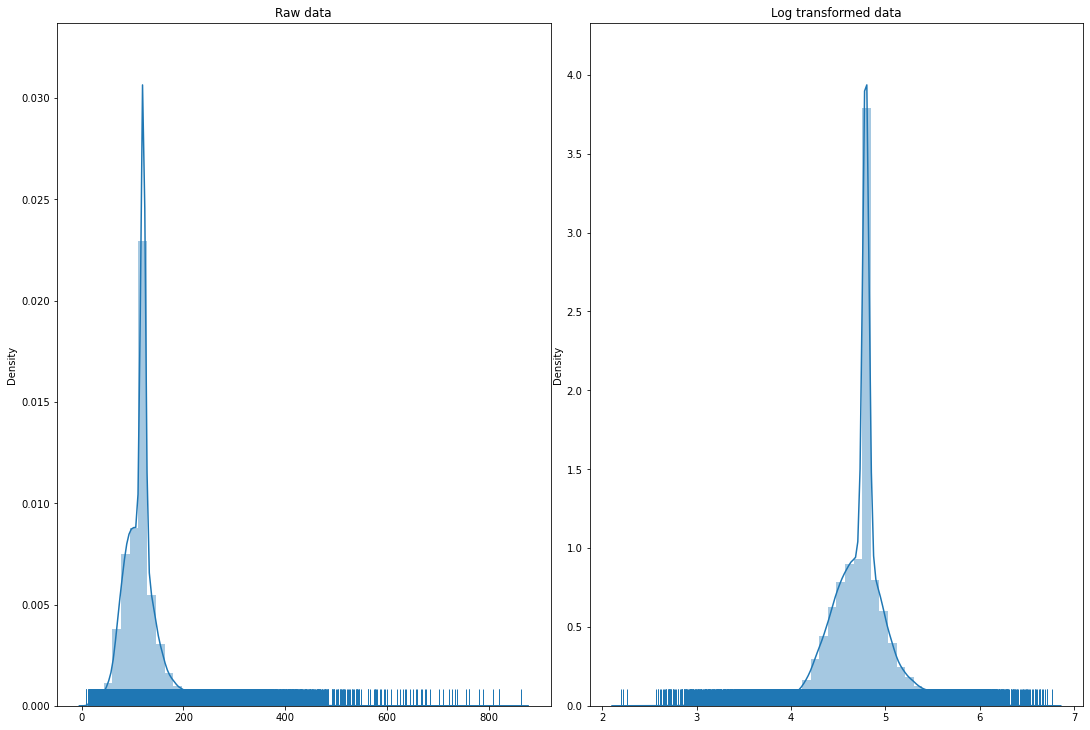

In [102]:
xc0 = clean_data(X0,mean=True)
fig, axes = plt.subplots(1,2,figsize=(15,10))

sns.distplot(X0[:,0] , rug=True, ax=axes[0])
sns.distplot(apply_log(xc0,columns_right_skewed0)[:,0], rug=True, ax=axes[1])
axes[0].set_title("Raw data")
axes[1].set_title("Log transformed data")
plt.tight_layout(pad=0.2)
plt.savefig("Data Transformation")
plt.show()

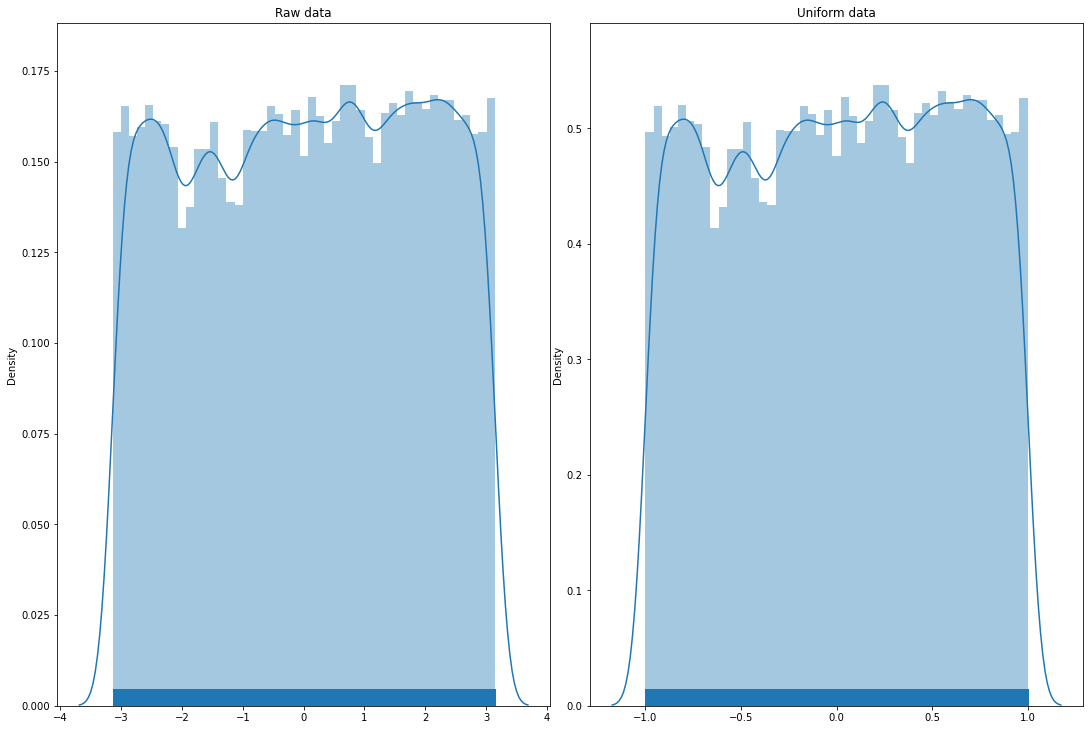

In [103]:
xc0 = clean_data(X0,mean=True)
fig, axes = plt.subplots(1,2,figsize=(15,10))

sns.distplot(X0[:,18] , rug=True, ax=axes[0])
sns.distplot(unif(X0,unif_0)[:,18], rug=True, ax=axes[1])
axes[0].set_title("Raw data")
axes[1].set_title("Uniform data")
plt.tight_layout(pad=0.2)
plt.savefig("Data_Transformation_unif")
plt.show()

---

## Data Cleaning

**All feature Cleaning:**

In [7]:
X0 = clean_data(X0, mean=True)
X1 = clean_data(X1, mean=True)
X2 = clean_data(X2, mean=True)
X3 = clean_data(X3, mean=True)

classifier_0 = {11 : [-1,1]}
classifier_1 = {11 : [-1,1]}
classifier_2 = {11 : [-1, 1], 12: [0, 1]}
classifier_3 = {11 : [-1, 1], 12: [0, 1]}
X0 = classify(X0, classifier_0)
X1 = classify(X1, classifier_1)
X2 = classify(X2, classifier_2)
X3 = classify(X3, classifier_3)

unif_0 = [14, 15, 17, 18, 20]
unif_1 = [14, 15, 17, 18, 20, 25]
unif_2 = [14, 15, 17, 18, 20, 25, 28]
unif_3 = [14, 15, 17, 18, 20, 25, 28]
X0 = unif(X0, unif_0)
X1 = unif(X1, unif_1)
X2 = unif(X2, unif_2)
X3 = unif(X3, unif_3)

columns_right_skewed0 = [0, 2, 3, 8, 9, 13, 16]
columns_right_skewed1 = [0, 2, 3, 8, 9, 10, 13, 16, 19, 21, 23, 29]
columns_right_skewed23 =[0, 2, 5, 8, 9, 10, 13, 16, 19, 21, 23, 26, 29]
X0 = apply_log(X0,columns_right_skewed0)
X1 = apply_log(X1,columns_right_skewed1)
X2 = apply_log(X2,columns_right_skewed23)
X3 = apply_log(X3,columns_right_skewed23)


sqrt_0 = [1 ,10 ,19,21]
sqrt_1 = [1, 3, 19]
sqrt_2 = [1, 3, 4, 5, 9, 19]
sqrt_3 = [1, 3, 4, 5, 6, 9, 19]
X0 = square_root(X0, sqrt_0)
X1 = square_root(X1, sqrt_1)
X2 = square_root(X2, sqrt_2)
X3 = square_root(X3, sqrt_3)

num_jet0_del = [4, 5, 6, 8, 12, 22, 23, 24, 25, 26, 27, 28, 29]
num_jet1_del = [4, 5, 6, 12, 22, 26, 27, 28]
num_jet2_3_del = [22]
X0 = np.delete(X0, num_jet0_del, axis=1)
X1 = np.delete(X1, num_jet1_del, axis=1)
X2 = np.delete(X2, num_jet2_3_del, axis=1)
X3 = np.delete(X3, num_jet2_3_del, axis=1)
#col_names_0 = np.delete(col_names, num_jet0_del)
#col_names_1 = np.delete(col_names, num_jet1_del)
#col_names_2_3 = np.delete(col_names, num_jet2_3_del)

In [8]:
print(X0.shape, X1.shape, X2.shape, X3.shape)

(99913, 17) (77544, 22) (50379, 29) (22164, 29)


In [9]:
print(y0.shape, y1.shape, y2.shape, y3.shape)

(99913,) (77544,) (50379,) (22164,)


**Maybe if we don't find any difference between X2 and X3 will just work with the following concatenation**

In [10]:
X23 = np.concatenate((X2,X3),axis=0)
y23 = np.concatenate((y2,y3),axis=0)

----

## Model implementations and selection

### Cross validation:

In [11]:
def cross_validation(y, x, k_indices, k, lambda_, degree):
    """return the loss of ridge regression."""
    # ***************************************************
    # get k'th subgroup in test, others in train:
    test_indices = k_indices[k]
    train_indices = k_indices[~(np.arange(k_indices.shape[0]) == k)].reshape(-1)
    
    x_test = x[test_indices]
    x_train = x[train_indices]
    y_test = y[test_indices]
    y_train = y[train_indices]
    # ***************************************************
    
    # ***************************************************
    # form data with polynomial degree:
    x_train_poly = build_poly(x_train, degree)
    x_test_poly = build_poly(x_test, degree)
    # ***************************************************
    
    
    # ***************************************************
    # ridge regression:
    wstar,_ = ridge_regression(y_train, x_train_poly, lambda_)
    # ***************************************************

    # ***************************************************
    # calculate the loss for train and test data:
    loss_tr = compute_rmse(y_train, x_train_poly, wstar)
    loss_te = compute_rmse(y_test, x_test_poly, wstar)
    # ***************************************************
    
    return loss_tr, loss_te, wstar

In [12]:
def select_model(y, x, degrees, k_fold, lambdas, seed=1):
    #split the data
    k_indices = build_k_indices(y, k_fold, seed)

    #for each degree, we compute the best lambdas and the associated rmse
    best_lambdas = []
    best_rmses = []
    # for each degree
    for degree in degrees:
        #cross validation
        loss_te_degree = []
    
        for lambda_ in lambdas:
            loss_te_lambda = []
            
            for k in range(k_fold):
                _, loss_te, _ = cross_validation(y, x, k_indices, k, lambda_, degree)
                loss_te_lambda.append(loss_te)

            loss_te_degree.append(np.mean(loss_te_lambda))
        
        #index of best lambda for given degree
        ind_lambda_opt = np.argmin(loss_te_degree)
        ##append the best loss and best corresponding lambda for degree
        best_lambdas.append(lambdas[ind_lambda_opt])
        best_rmses.append(loss_te_degree[ind_lambda_opt])
        
    ind_opt = np.argmin(best_rmses)
    
    return degrees[ind_opt], lambdas[ind_opt]

**PRI_jet_num = 0**

In [65]:
x0_tr, y0_tr, x0_te, y0_te = split_data(X0, y0, ratio=0.7, seed=1)

In [66]:
print(x0_tr.shape, x0_te.shape)

(69939, 17) (29974, 17)


In [67]:
x0_tr, means, stds = standardize_data(x0_tr)
x0_te = (x0_te - means) / stds

In [68]:
x0_tr.shape

(69939, 17)

In [103]:
degrees = np.arange(2,6)
lambdas = np.logspace(-5, 0, 20)
k_fold = 10
select_model(y0_tr, x0_tr, degrees, k_fold, lambdas)

(5, 6.158482110660267e-05)

In [104]:
degree = 5
lambda_ = 6.158482110660267e-05

In [105]:
x0_tr = build_poly(x0_tr, degree)
x0_te = build_poly(x0_te, degree)

w0, loss0 = ridge_regression(y0_tr, x0_tr, lambda_)
y0_guessed = predict_labels(w0, x0_te)

In [106]:
accuracy(y0_guessed,y0_te)

84.30306265430039

**PRI_jet_num = 1**

In [73]:
x1_tr, y1_tr, x1_te, y1_te = split_data(X1, y1, ratio=0.7, seed=1)

In [74]:
print(x1_tr.shape, x1_te.shape)

(54280, 22) (23264, 22)


In [75]:
x1_tr, means, stds = standardize_data(x1_tr)
x1_te = (x1_te - means) / stds

In [110]:
degrees = np.arange(2,6)
lambdas = np.logspace(-5, 0, 40)
k_fold = 10
select_model(y1_tr, x1_tr, degrees, k_fold, lambdas)

(5, 2.424462017082331e-05)

In [111]:
degree = 5
lambda_ = 2.424462017082331e-05

In [112]:
x1_tr = build_poly(x1_tr, degree)
x1_te = build_poly(x1_te, degree)

In [113]:
w1, loss1 = ridge_regression(y1_tr, x1_tr, lambda_)
y1_guessed = predict_labels(w1, x1_te)

In [115]:
accuracy(y1_guessed,y1_te)

77.77682255845943

**PRI_jet_num = 2**

In [14]:
x2_tr, y2_tr, x2_te, y2_te = split_data(X2, y2, ratio=0.7, seed=1)

In [15]:
degrees = np.arange(2,10)
lambdas = np.logspace(-5, 0, 50)
k_fold = 10
select_model(y2_tr, x2_tr, degrees, k_fold, lambdas)

(6, 2.559547922699533e-05)

In [20]:
degree = 6
lambda_ = 2.56e-05

In [21]:
w2, loss2 = ridge_regression(y2_tr, x2_tr, lambda_)
y2_guessed = predict_labels(w2, x2_te)

In [22]:
accuracy(y2_guessed,y2_te)

72.68757443429932

**PRI_jet_num = 3**

In [16]:
x3_tr, y3_tr, x3_te, y3_te = split_data(X3, y3, ratio=0.7, seed=1)

In [23]:
degrees = np.arange(2,7)
lambdas = np.logspace(-5, 0, 50)
k_fold = 5
select_model(y3_tr, x3_tr, degrees, k_fold, lambdas)

(6, 2.559547922699533e-05)

In [24]:
degree = 6
lambda_ = 2.56e-05

In [25]:
x3_tr = build_poly(x3_tr, degree)
x3_te = build_poly(x3_te, degree)

In [26]:
w3, loss3 = ridge_regression(y3_tr, x3_tr, lambda_)
y3_guessed = predict_labels(w3, x3_te)

In [27]:
accuracy(y3_guessed,y3_te)

80.69172932330827

----

In [60]:
def cross_validation_visualization(lambds, mse_tr, mse_te):
    """visualization the curves of mse_tr and mse_te."""
    plt.figure(figsize=(15,10))
    plt.semilogx(lambds, mse_tr, marker=".", color='b', label='train error')
    plt.semilogx(lambds, mse_te, marker=".", color='r', label='test error')
    plt.xlabel("lambdas")
    plt.ylabel("rmse")
    plt.title("cross validation")
    plt.legend(loc=2)
    plt.grid(True)
    plt.savefig("cross_validationjet0")

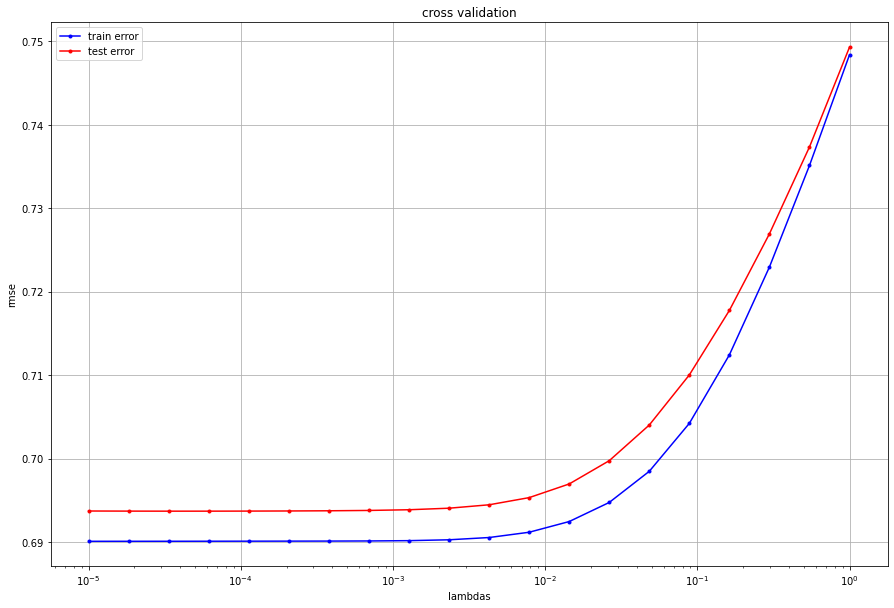

In [70]:
def cross_validation_demo(y , x):
    seed = 1
    k_fold = 10
    degree = 5
    lambdas = np.logspace(-5, 0, 20)
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    # ***************************************************
    for lambda_ in lambdas:
        loss_tr_lambda = []
        loss_te_lambda = []
        
        for k in range(k_fold):
            loss_tr, loss_te, _ = cross_validation(y, x, k_indices, k, lambda_, degree)
            loss_tr_lambda.append(loss_tr)
            loss_te_lambda.append(loss_te)
            
        rmse_tr.append(np.mean(loss_tr_lambda))
        rmse_te.append(np.mean(loss_te_lambda))
    # ***************************************************    
    cross_validation_visualization(lambdas, rmse_tr, rmse_te)

cross_validation_demo(y0_tr,x0_tr)

----

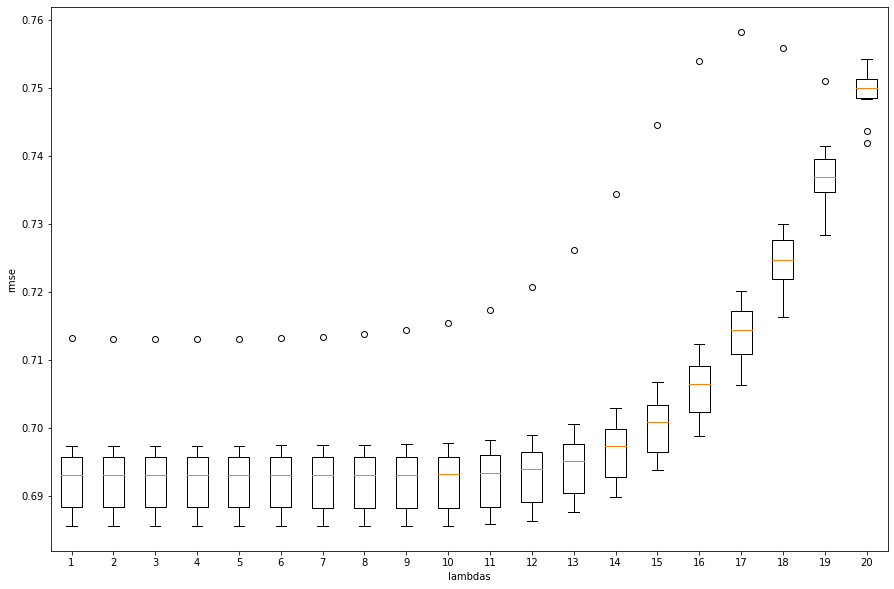

In [104]:
def extended_cross_validation_demo(x, y):
    seed = 1
    degree = 5
    k_fold = 10
    lambdas = np.logspace(-5, 0, 20)
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    variances = []
    
    # cross validation
    for lambda_ in lambdas:
        rmse_tr_tmp = []
        rmse_te_tmp = []
        
        for k in range(k_fold):
            loss_tr, loss_te,_ = cross_validation(y, x, k_indices, k, lambda_, degree)
            rmse_tr_tmp.append(loss_tr)
            rmse_te_tmp.append(loss_te)
            
        rmse_tr.append(rmse_tr_tmp)
        rmse_te.append(rmse_te_tmp)
        variances.append(loss_te)
    
    plt.figure(figsize=(15,10))
    plt.xlabel("lambdas")
    plt.ylabel("rmse")
    plt.boxplot(rmse_te)
    plt.savefig("boxplot_jet0")

extended_cross_validation_demo(x0_tr,y0_tr)

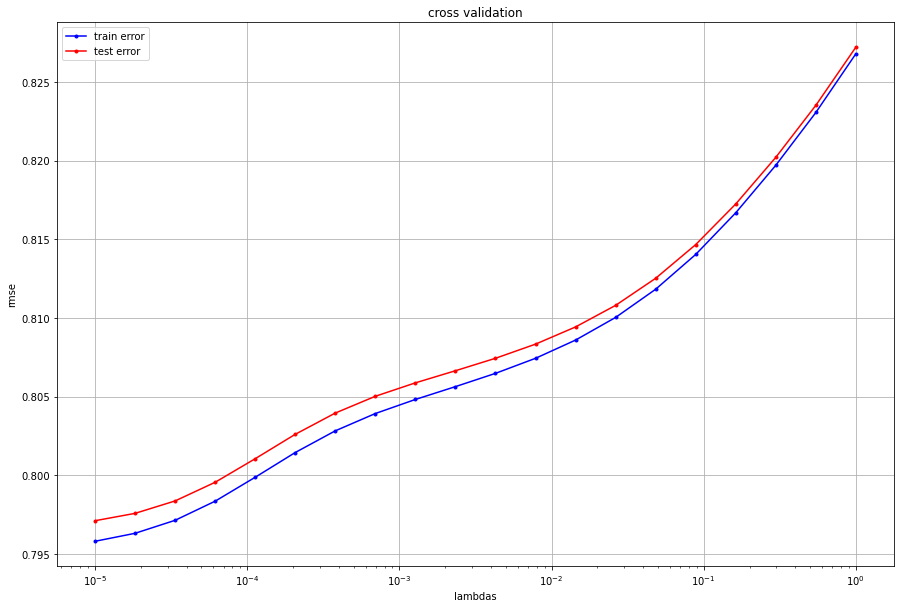

In [78]:
cross_validation_demo(y1,X1)

---

#### Cross validation for logistic regression:

**PRI_jet_num = 0**

In [46]:
x0_tr, y0_tr, x0_te, y0_te = split_data(X0, y0, ratio=0.7, seed=1)

In [47]:
print(x0_tr.shape, x0_te.shape)

(69939, 17) (29974, 17)


In [48]:
x0_tr, means, stds = standardize_data(x0_tr)
x0_te = (x0_te - means) / stds

In [49]:
x0_tr.shape

(69939, 17)

In [50]:
def logistic_cross_validation(y, x, k_indices, k, degree):
    """return the loss of ridge regression."""
    # ***************************************************
    # get k'th subgroup in test, others in train:
    test_indices = k_indices[k]
    train_indices = k_indices[~(np.arange(k_indices.shape[0]) == k)].reshape(-1)
    
    x_test = x[test_indices]
    x_train = x[train_indices]
    y_test = y[test_indices]
    y_train = y[train_indices]
    # ***************************************************
    
    # ***************************************************
    # form data with polynomial degree:
    x_train_poly = build_poly(x_train, degree)
    x_test_poly = build_poly(x_test, degree)
    # ***************************************************
    
    
    # ***************************************************
    # logistic regression:
    initial_w = np.random.rand(x_train_poly.shape[1])
    wstar,_ = logistic_regression(y_train, x_train_poly, initial_w, max_iters=2000, gamma = 10e-6)
    # ***************************************************

    # ***************************************************
    # calculate the loss for train and test data:
    loss_tr = compute_rmse(y_train, x_train_poly, wstar)
    loss_te = compute_rmse(y_test, x_test_poly, wstar)
    # ***************************************************
    
    return loss_tr, loss_te, wstar

In [ ]:
def cross_validation_demo():
    seed = 1
    k_fold = 5
    degrees = range(2,10)
    # split data in k fold
    k_indices = build_k_indices(y0_tr, k_fold, seed)
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    # ***************************************************
    for degree in degrees:
        loss_tr_degree = []
        loss_te_degree = []
        
        for k in range(k_fold):
            loss_tr, loss_te, _ = logistic_cross_validation(y0_tr, x0_tr, k_indices, k, degree)
            loss_tr_degree.append(loss_tr)
            loss_te_degree.append(loss_te)
            
        rmse_tr.append(np.mean(loss_tr_degree))
        rmse_te.append(np.mean(loss_te_degree))
    # ***************************************************    
    cross_validation_visualization(lambdas, rmse_tr, rmse_te)

cross_validation_demo()

----

### Visualizations:

In [83]:
import warnings
warnings.filterwarnings("ignore")


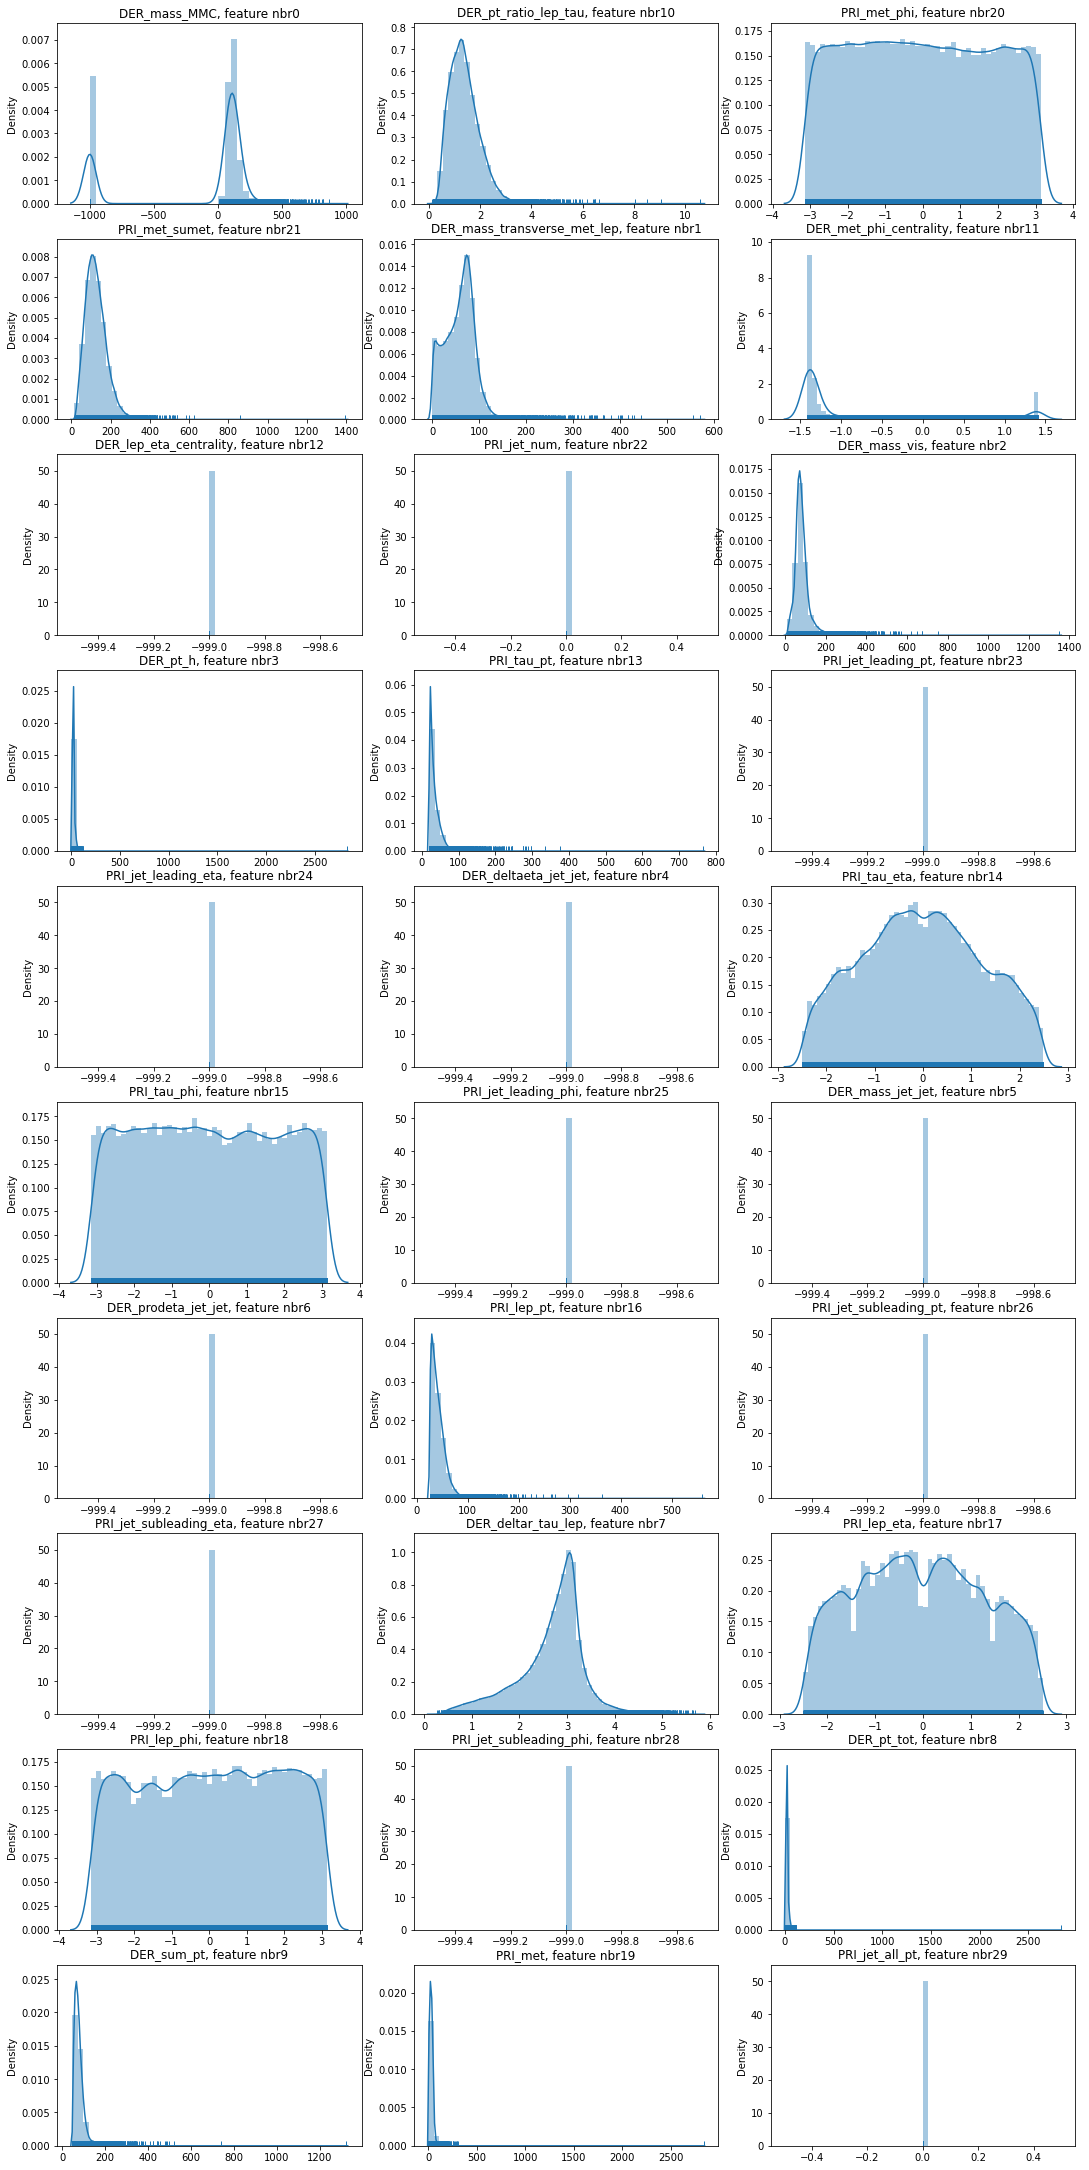

In [84]:
histogram(X0, dict_indexToName)

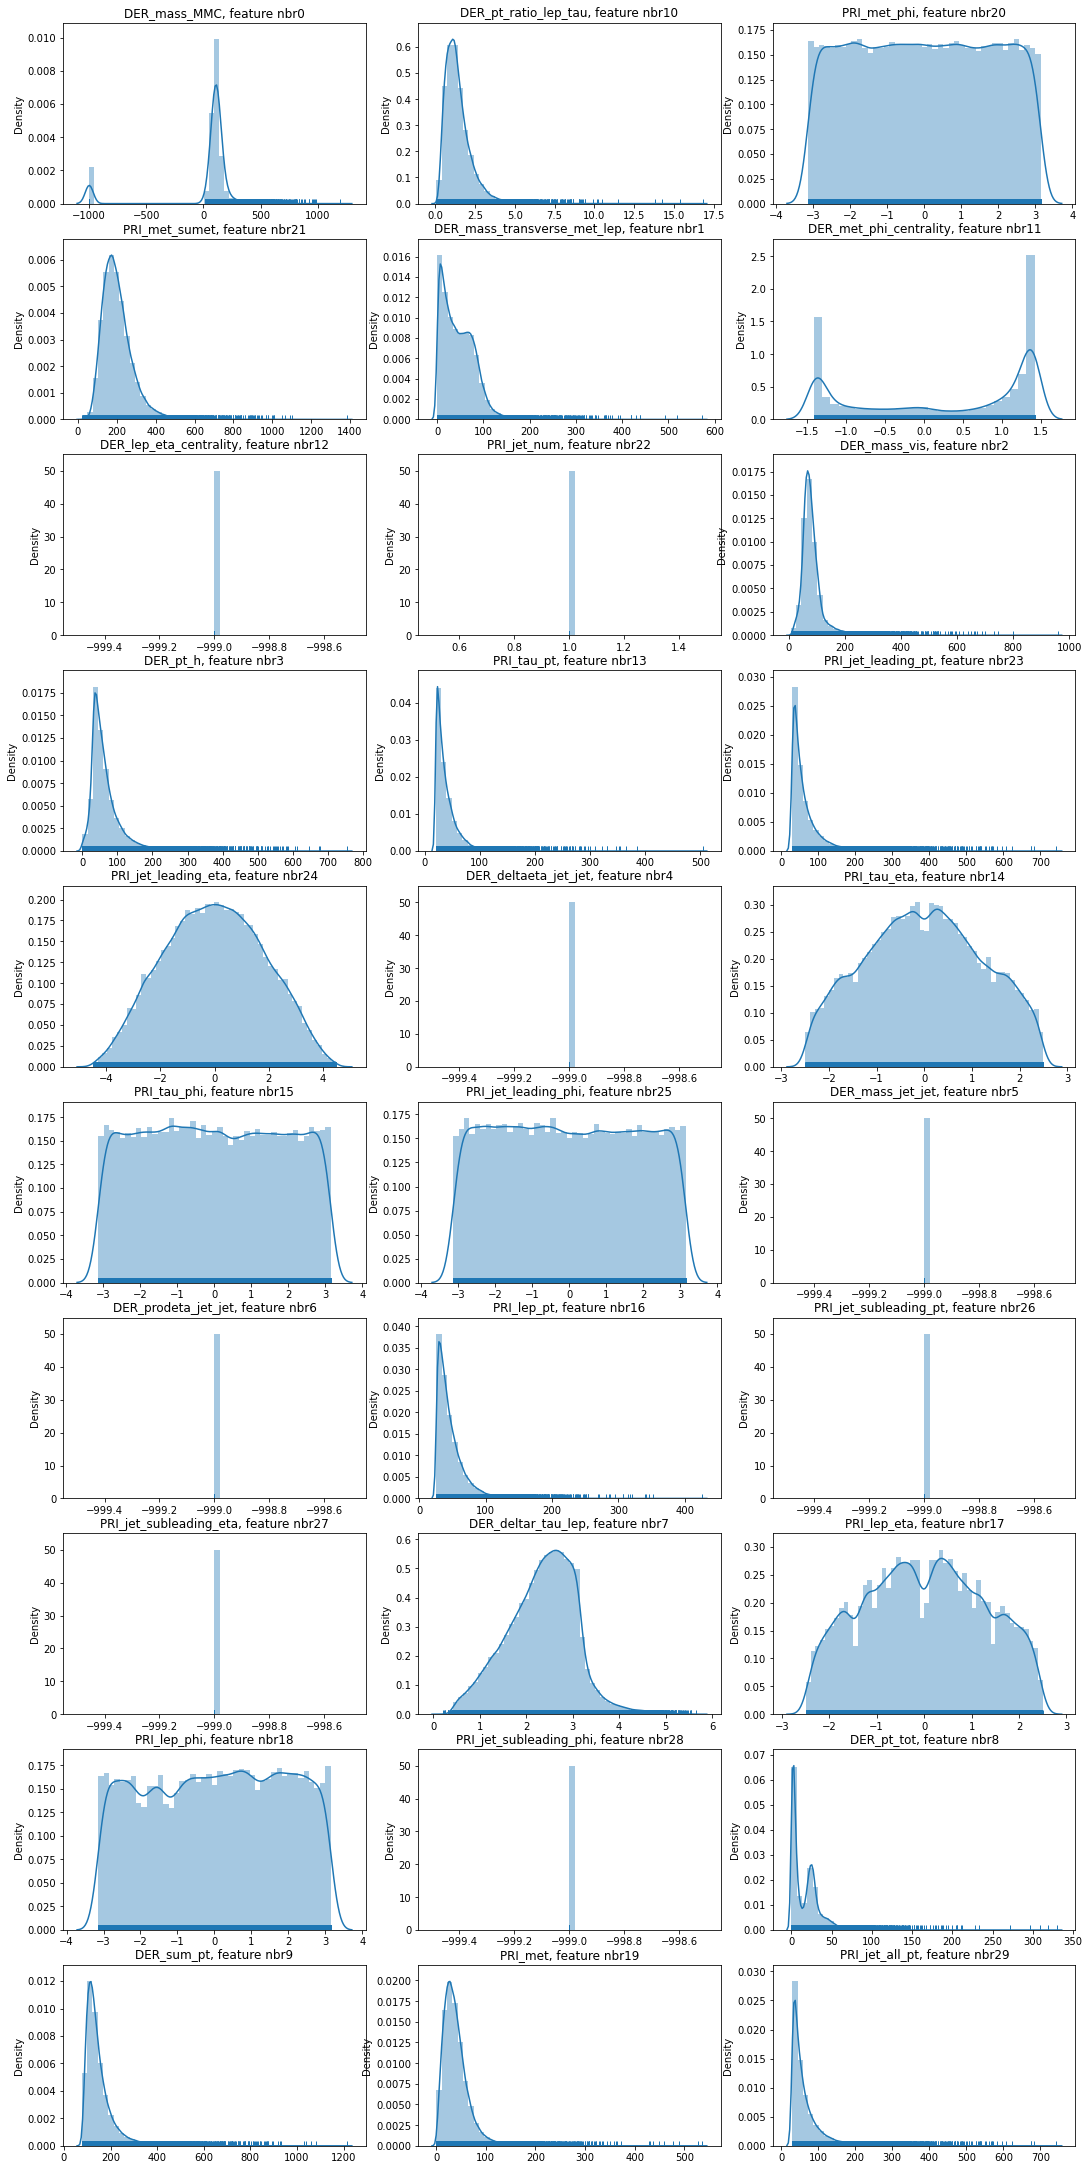

In [105]:
histogram(X1, dict_indexToName)

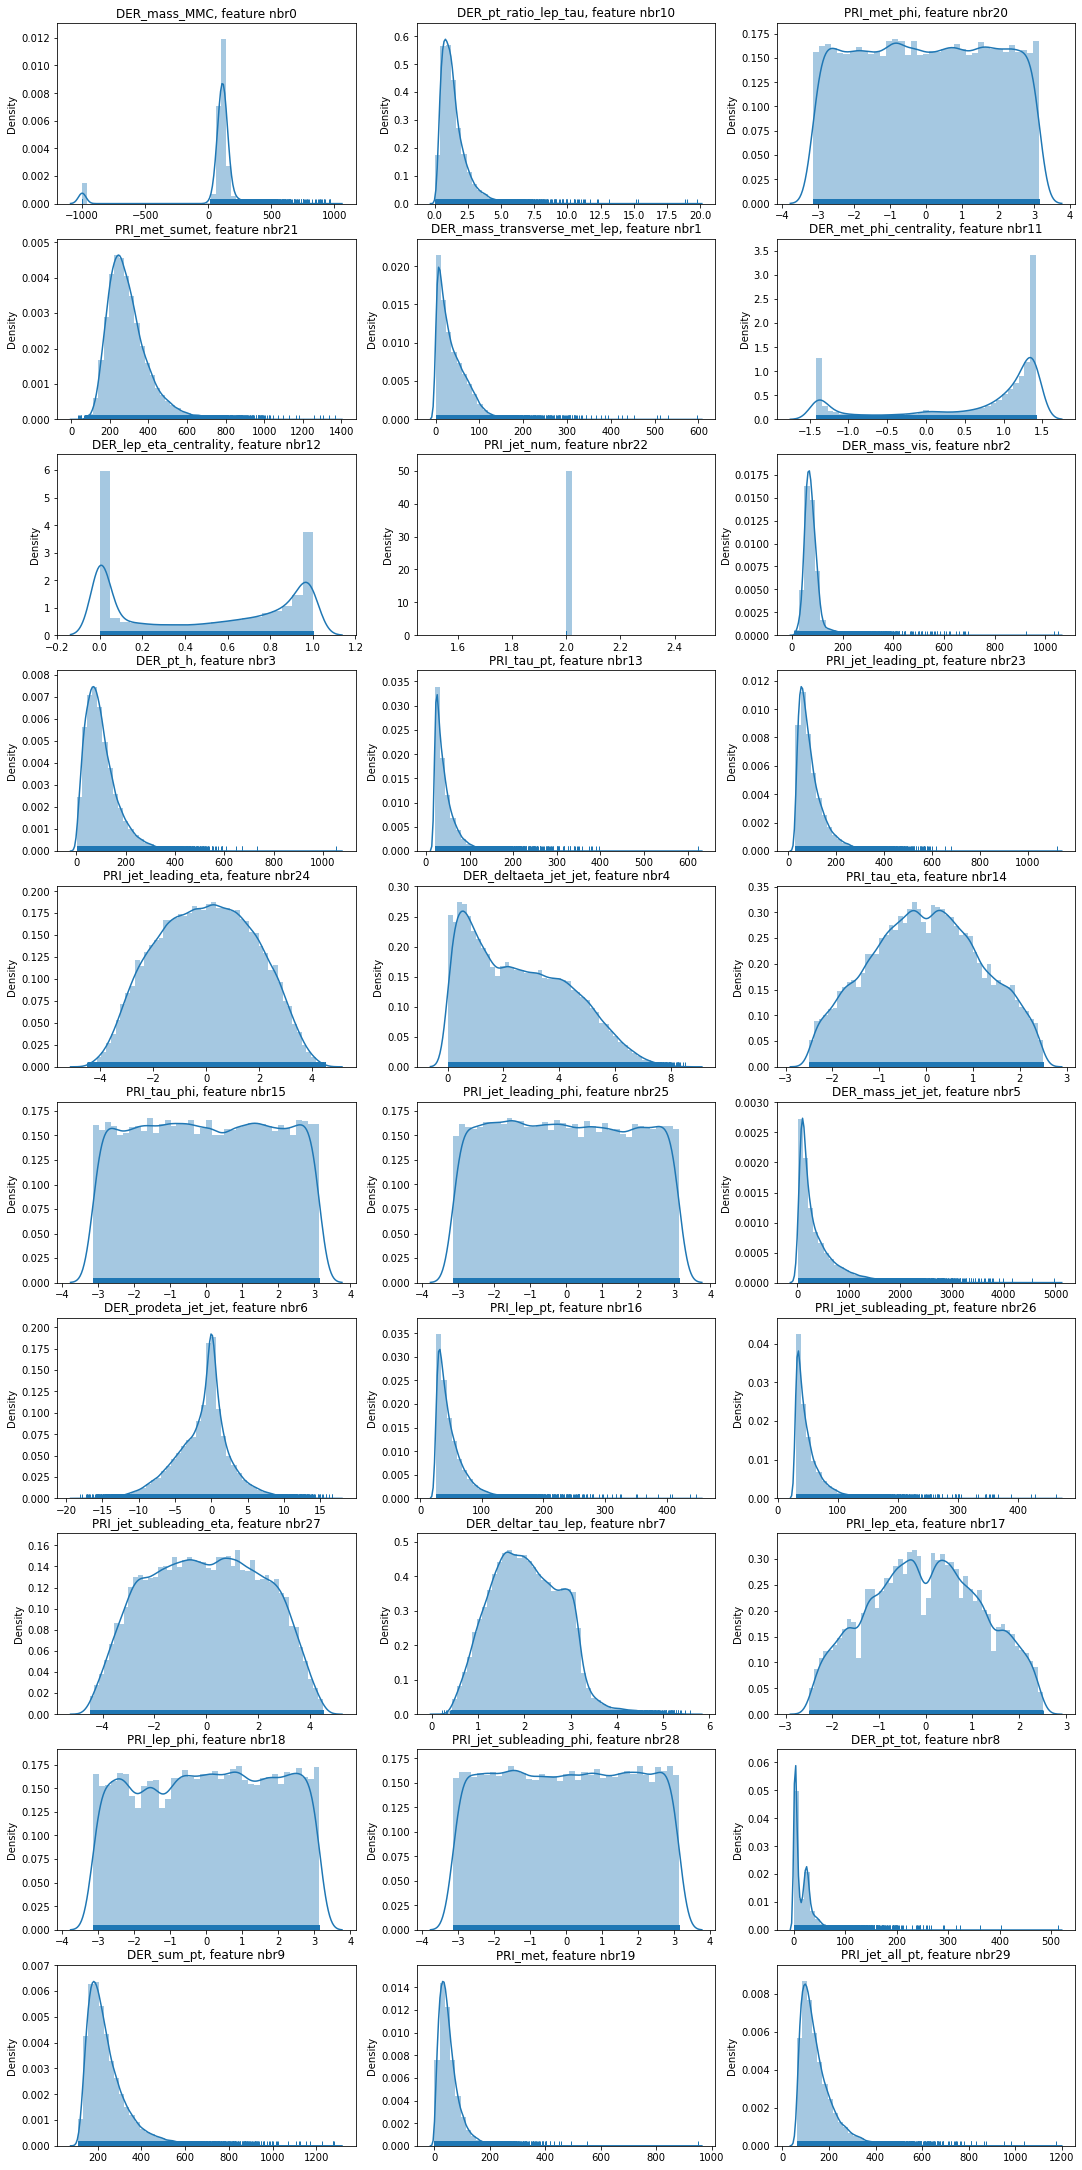

In [106]:
histogram(X2, dict_indexToName)

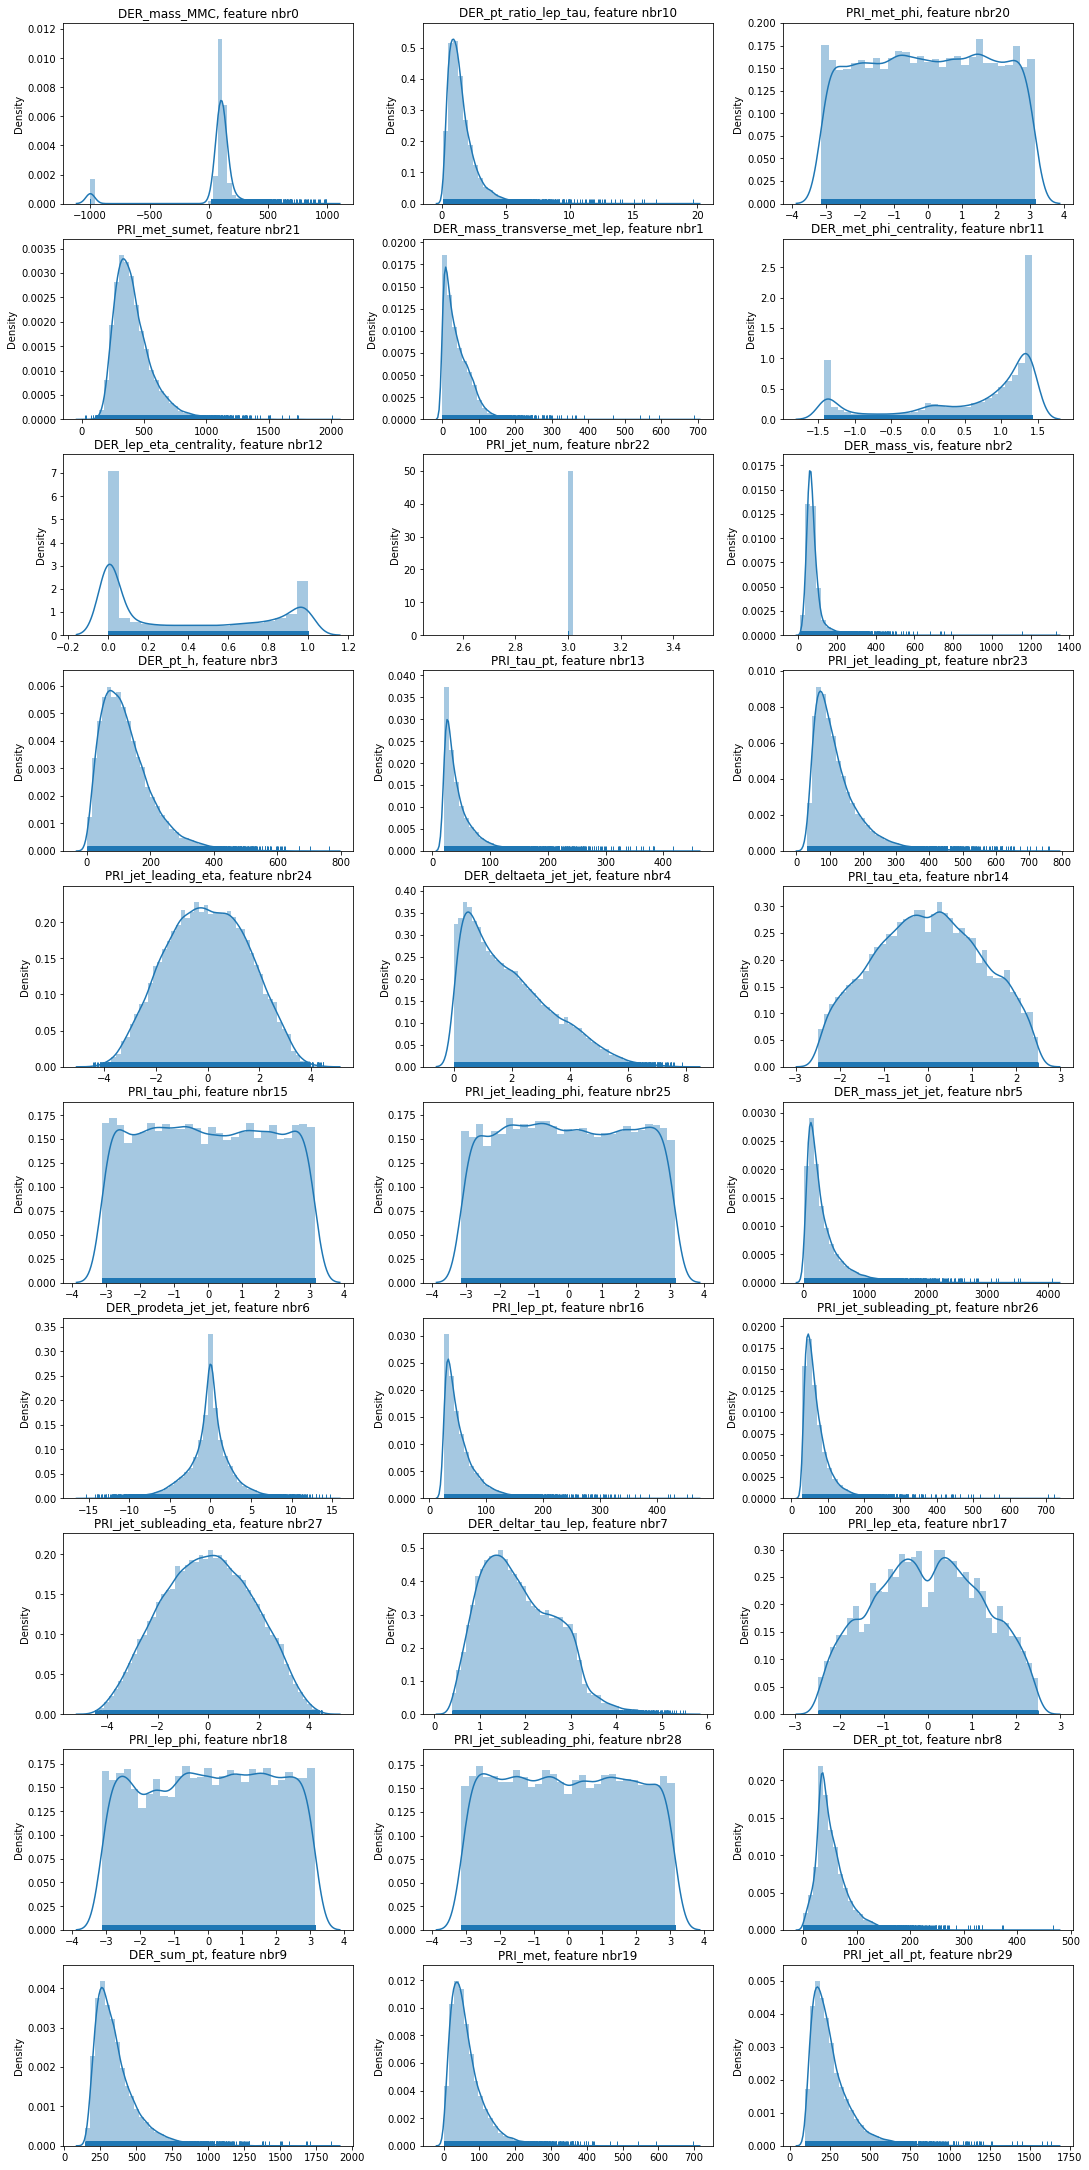

In [107]:
histogram(X3, dict_indexToName)